In [16]:
from os import listdir
from os.path import isfile, join
import cv2
from matplotlib import pyplot as plt
import kerem
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 30]

root_path = '../datasets/'
file_names = [f for f in listdir(root_path) if isfile(join(root_path, f))]

image_storage = dict()

for file_name in file_names:
    image_storage[file_name.split('.')[0]] = cv2.imread(root_path + file_name)

In [17]:
cv2.__version__

'4.5.2'

In [18]:
img1 = image_storage['mf08']
img2 = image_storage['wf']

img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
#img1 = kerem.downsize_image(img1, 20)
#img1 = kerem.upsize_image(img1, 20)


In [19]:
sift1 =cv2.SIFT_create(
    #nfeatures=100,
    #nOctaveLayers=..., 
    contrastThreshold=0.016,
    #edgeThreshold=0, 
    #sigma=...
)
# find the keypoints and descriptors with SIFT
kp1, des1 = sift1.detectAndCompute(img1,None)


In [20]:
sift2 =cv2.SIFT_create(
    #nfeatures=10000,
    #nOctaveLayers=20, 
    contrastThreshold=0.002, 
    #edgeThreshold=1000, 
    #sigma=0.03,
    #descriptorType=5,
)
kp2, des2 = sift2.detectAndCompute(img2,None)

In [21]:
print(len(kp1))
print(len(kp2))

48170
535014


In [22]:
print(des1.shape)
print(des2.shape)

(48170, 128)
(535014, 128)


plt.imshow(cv2.drawKeypoints(img2_gray,kp2,img2_gray,flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS))

plt.imshow(cv2.drawKeypoints(img1_gray,kp1,img1_gray,flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS))

In [23]:
def flann_matcher():
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 15)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    return good

def bf_matcher():
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck= False)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x:x.distance)

    return matches[:10]

good = flann_matcher()
#good = bf_matcher()

In [24]:
len(good)

54

In [25]:
src_pts = np.float64([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float64([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

im_dst = cv2.warpPerspective(img1,M,(img2.shape[1],img2.shape[0]), borderMode=cv2.BORDER_TRANSPARENT)

In [26]:
def panorama(img1, img2, H, size):
   I = np.linalg.inv(H)
   img = np.zeros(size,dtype=np.uint8)
   img.fill(255)
   img = cv2.warpPerspective(img1, np.identity(3), size, img, borderMode=cv2.BORDER_TRANSPARENT)
   img = cv2.warpPerspective(img2, I, size, img, flags=cv2.WARP_INVERSE_MAP+cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT)
   return img
im_dst = panorama(img2, img1, M, (img2.shape[1], img2.shape[0]))

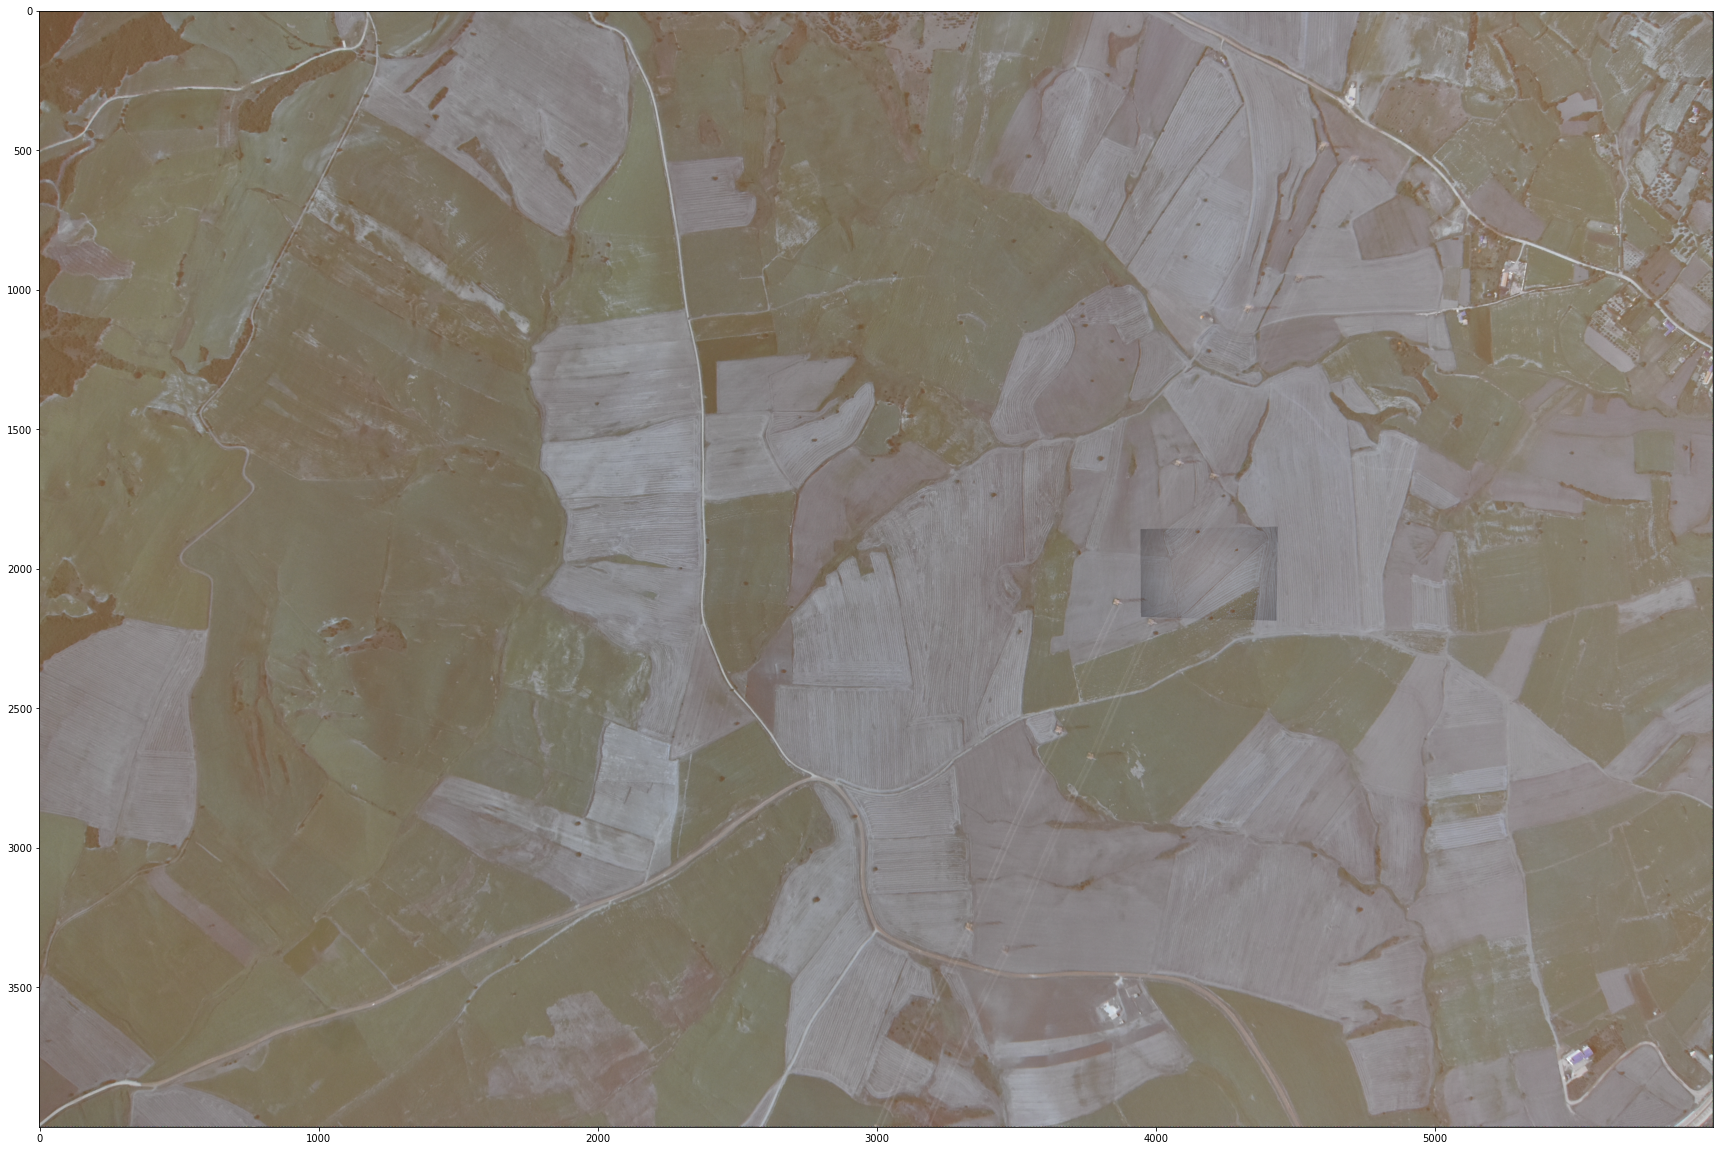

In [27]:
plt.imshow(im_dst)

cv2.imwrite('../results/v3/mf11_updated.JPG', im_dst)


matchesMask = mask.ravel().tolist()
h,w,d = img1.shape
#https://learnopencv.com/homography-examples-using-opencv-python-c/
"""

matchesMask = mask.ravel().tolist()
h,w,d = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
"""

img1.shape


MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w,d = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None


draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3),plt.show()


cv2.imwrite('../results/v2/mf11.JPG', img3)

kerem.show_images(
    [img3],
    divided_by=6
)